# Imports & Global Setup

In [2]:
import cv2
import glob
import os
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams["figure.max_open_warning"] = 0
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['axes.labelsize'] = 8

DATA_DIR = "./Dataset/Option 1/"
OUTPUT_DIR = "./Matches/"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# tuning params
PREPROCESS = True
RESIZE_WIDTH = 1500
RATIO_TEST = 0.7
SAVE_RESULTS = False


# Load Images

In [3]:
def load_images_from_folder(folder_path, resize_width=None):
    image_paths = sorted(
        glob.glob(os.path.join(folder_path, "*.jpg")) +
        glob.glob(os.path.join(folder_path, "*.jpeg"))
    )
    if len(image_paths) == 0:
        raise FileNotFoundError(f"No images found in {folder_path}")

    images = []
    for path in image_paths:
        img = cv2.imread(path)
        if img is None:
            print(f"Skipping unreadable image: {path}")
            continue

        if resize_width:
            h, w = img.shape[:2]
            scale = resize_width / float(w)
            img = cv2.resize(img, (resize_width, int(h * scale)))
        images.append(img)
    return images, image_paths

images, paths = load_images_from_folder(DATA_DIR, resize_width=RESIZE_WIDTH)
print(f"Loaded {len(images)} images from {DATA_DIR}")


Loaded 24 images from ./Dataset/Option 1/


# Preprocessing

In [4]:
def preprocess_image(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    equalized = clahe.apply(gray)
    blurred = cv2.GaussianBlur(equalized, (3,3), 0)
    kernel = np.array([[0, -1, 0],
                       [-1, 5,-1],
                       [0, -1, 0]])
    sharpened = cv2.filter2D(blurred, -1, kernel)
    return sharpened

# Visualization Grid

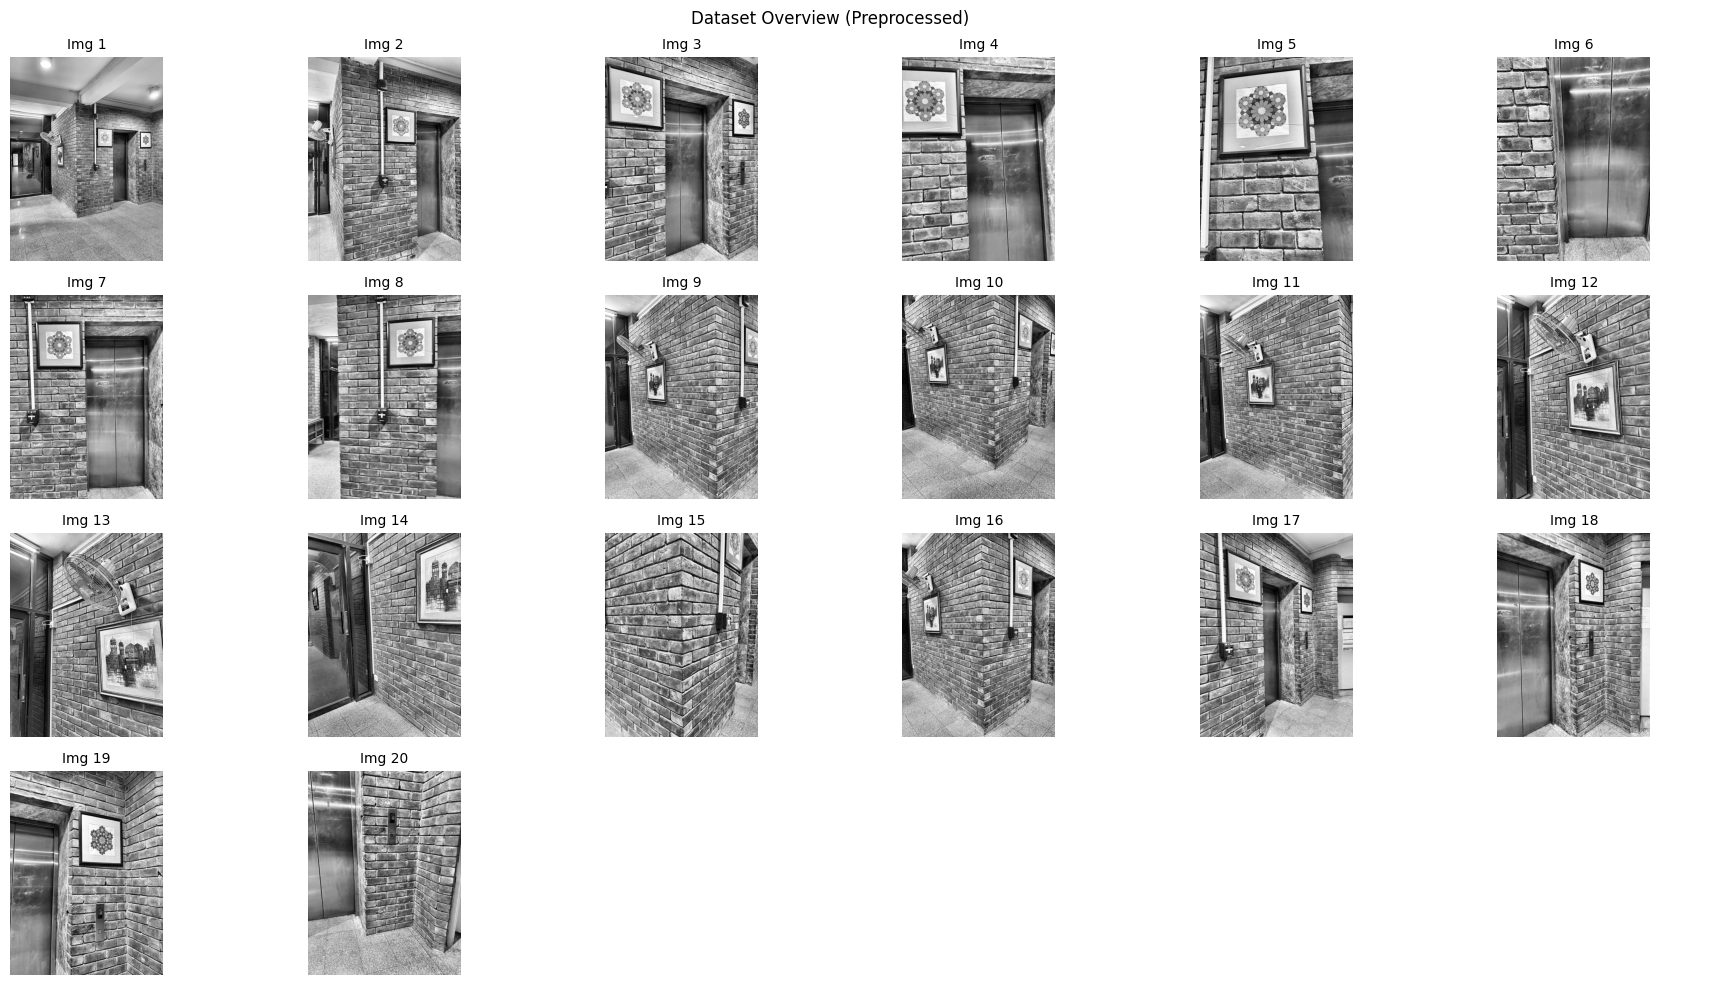

In [5]:
def visualize_dataset_grid(images, cols=5, preprocess=False, max_images=20):
    n = min(len(images), max_images)
    rows = int(np.ceil(n / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(3*cols, 2.5*rows))
    axes = axes.ravel()

    for i in range(rows*cols):
        ax = axes[i]
        if i < n:
            img = images[i]
            img_disp = preprocess_image(img) if preprocess else cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            cmap = 'gray' if preprocess else None
            ax.imshow(img_disp, cmap=cmap)
            ax.set_title(f"Img {i+1}")
        ax.axis('off')

    plt.suptitle("Dataset Overview" + (" (Preprocessed)" if preprocess else ""), fontsize=12)
    plt.tight_layout()
    plt.show()

visualize_dataset_grid(images, cols=6, preprocess=True)


# Feature Detection and Matching

In [6]:
def match_features(img1, img2, ratio_thresh=0.7):
    sift = cv2.SIFT_create()
    kp1, des1 = sift.detectAndCompute(img1, None)
    kp2, des2 = sift.detectAndCompute(img2, None)

    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(des1, des2, k=2)
    good_matches = [m for m, n in matches if m.distance < ratio_thresh * n.distance]

    print(f"{len(good_matches)} good matches out of {len(matches)} total")
    return kp1, kp2, good_matches


# Match Visualization

1432 good matches out of 36351 total
1460 good matches out of 41608 total
1007 good matches out of 31395 total
802 good matches out of 18610 total
291 good matches out of 31146 total
487 good matches out of 26596 total
591 good matches out of 36085 total
98 good matches out of 23348 total
4764 good matches out of 54120 total
1935 good matches out of 63779 total
1925 good matches out of 54435 total
2989 good matches out of 36470 total
1770 good matches out of 42200 total
93 good matches out of 48226 total
2549 good matches out of 62284 total
1637 good matches out of 65699 total
930 good matches out of 38472 total
475 good matches out of 31211 total
376 good matches out of 36070 total
501 good matches out of 46254 total


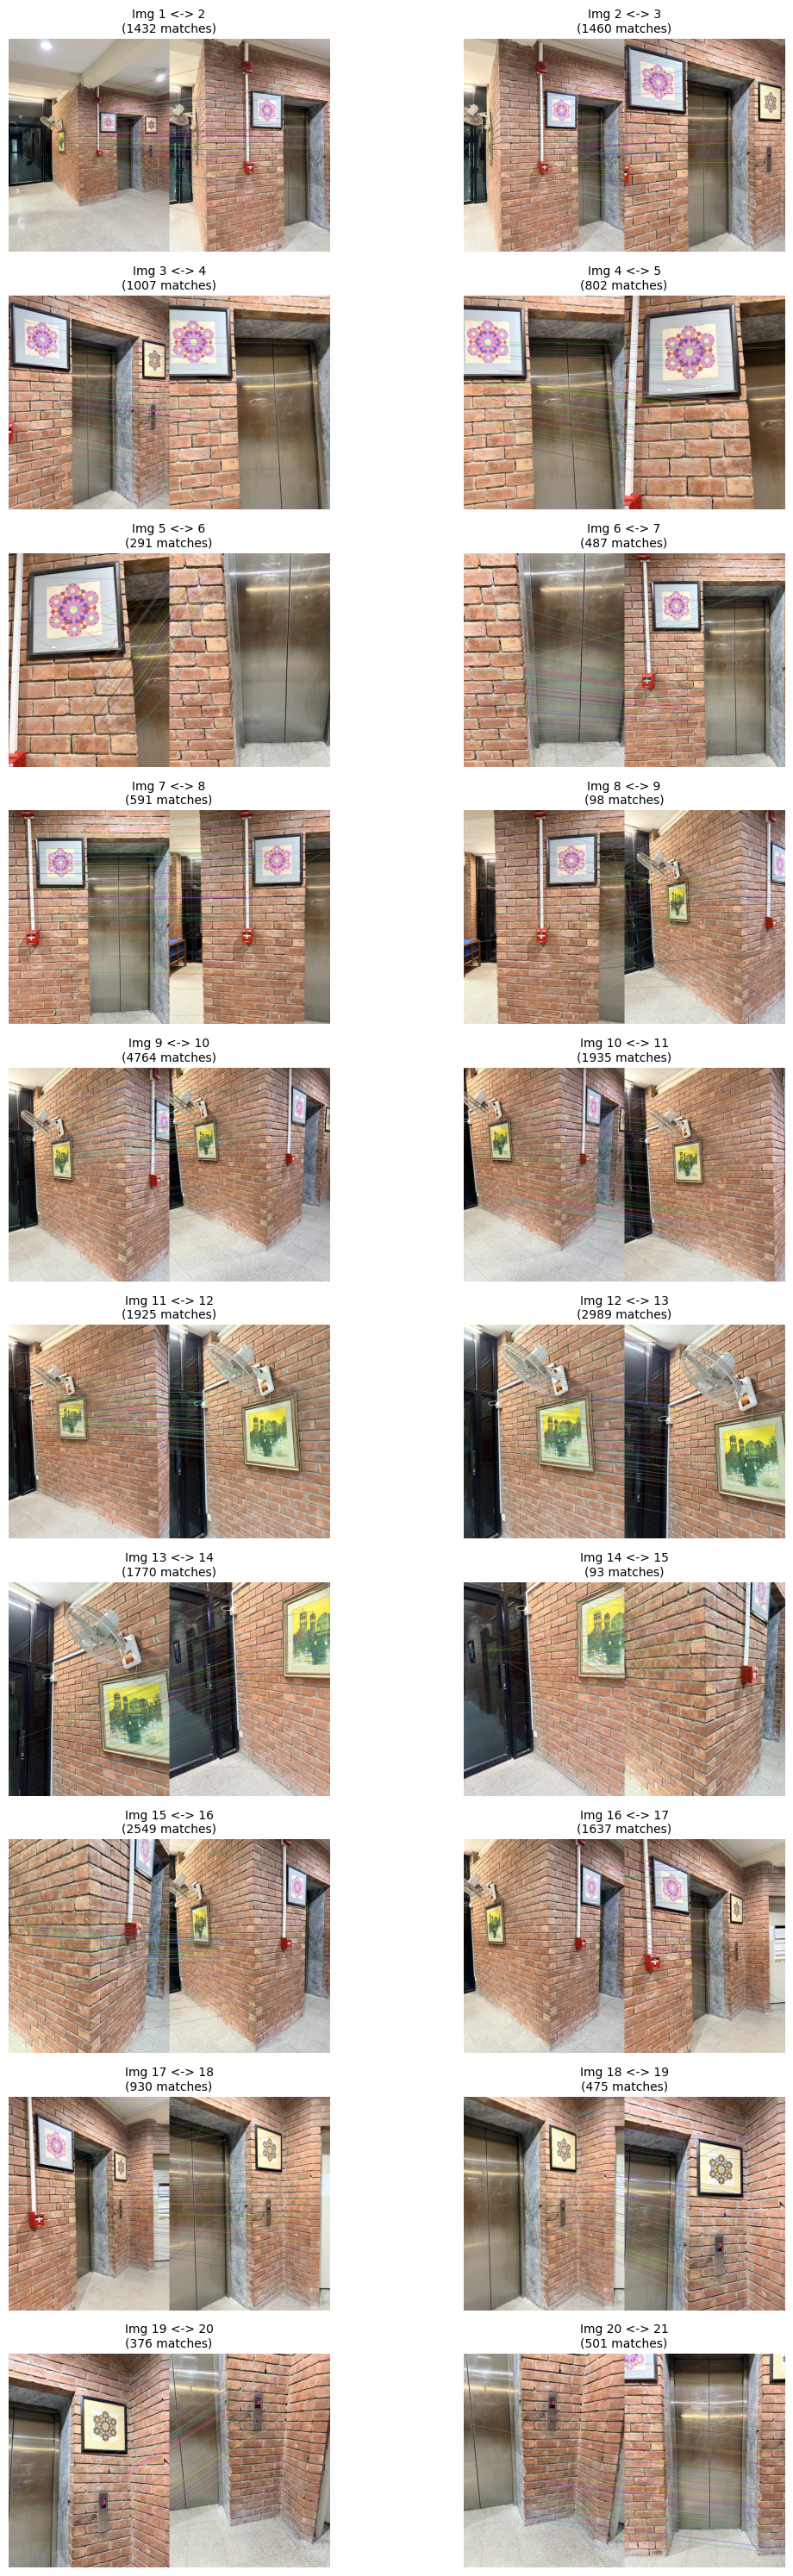

In [7]:
def visualize_matches(img1, img2, kp1, kp2, matches, title="", max_lines=80):
    matches_to_draw = sorted(matches, key=lambda x: x.distance)[:max_lines]
    matched_vis = cv2.drawMatches(
        img1, kp1, img2, kp2, matches_to_draw, None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )
    return cv2.cvtColor(matched_vis, cv2.COLOR_BGR2RGB)

def visualize_all_matches_grid(images, ratio_thresh=0.7, cols=3, max_pairs=9):
    n_pairs = min(len(images) - 1, max_pairs)
    rows = int(np.ceil(n_pairs / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 3*rows))
    axes = axes.ravel()

    for i in range(rows*cols):
        ax = axes[i]
        if i < n_pairs:
            img1, img2 = images[i], images[i+1]
            if PREPROCESS:
                img1 = preprocess_image(img1)
                img2 = preprocess_image(img2)
            kp1, kp2, good_matches = match_features(img1, img2, ratio_thresh)
            vis = visualize_matches(images[i], images[i+1], kp1, kp2, good_matches)
            ax.imshow(vis)
            ax.set_title(f"Img {i+1} <-> {i+2}\n({len(good_matches)} matches)")
        ax.axis('off')
    plt.tight_layout()
    plt.show()

visualize_all_matches_grid(images, ratio_thresh=RATIO_TEST, cols=2, max_pairs=20)